In [45]:
!pip3 install html5lib
import requests
from bs4 import BeautifulSoup
import pandas as pd
!pip3 install sodapy
from sodapy import Socrata

In [46]:
#data collection
#we can access the dataset via the SODA API
#since the dataset has too many rows, we will only process the first 100 thousand rows.
client = Socrata("data.montgomerycountymd.gov", 'IXCx2ihjCYo4RF9slAVzYL2x9')
results = client.get("4mse-ku6q",limit=100000)
df = pd.DataFrame.from_records(results)
df.head()

,seq_id,date_of_stop,time_of_stop,agency,subagency,description,location,latitude,longitude,accident,...,:@computed_region_kbsp_ykn9,:@computed_region_d7bw_bq6x,:@computed_region_rbt8_3x7n,search_conducted,search_outcome,search_reason_for_stop,search_disposition,search_reason,search_type,search_arrest_reason
0,934e4a53-bf83-4da1-8206-3c135d9ee350,2020-11-20T00:00:00.000,22:53:00,MCP,"2nd District, Bethesda",FAILURE TO DISPLAY TWO LIGHTED FRONT LAMPS WHE...,ROCKVILLE PIKE AT EDMONSTON DR,39.0750783333333,-77.133821,No,...,25,68,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8bf263e5-a9ce-434d-bb56-113ff6020d48,2020-11-20T00:00:00.000,22:42:00,MCP,"3rd District, Silver Spring",EXCEEDING THE POSTED SPEED LIMIT OF 50 MPH,29 NORTH & GREEN CASTLE BLVD,39.0941343333333,-76.9388291666667,No,...,53,47,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,88a3318d-aa40-4666-9e1e-00cdb91b7aa2,2020-11-20T00:00:00.000,22:41:00,MCP,"3rd District, Silver Spring",DRIVER OF MOTOR VEHICLE FOLLOWING VEHICLE CLOS...,GEROGIA AVE/ UNIVERSITY BLVD,39.0452711666667,-77.0521368333333,No,...,16,17,1,No,Warning,21-801.1,NaN,NaN,NaN,NaN
3,88a3318d-aa40-4666-9e1e-00cdb91b7aa2,2020-11-20T00:00:00.000,22:41:00,MCP,"3rd District, Silver Spring",DRIVER FAILURE TO OBEY PROPERLY PLACED TRAFFIC...,GEROGIA AVE/ UNIVERSITY BLVD,39.0452711666667,-77.0521368333333,No,...,16,17,1,No,Warning,21-801.1,NaN,NaN,NaN,NaN
4,88a3318d-aa40-4666-9e1e-00cdb91b7aa2,2020-11-20T00:00:00.000,22:41:00,MCP,"3rd District, Silver Spring",EXCEEDING THE POSTED SPEED LIMIT OF 35 MPH,GEROGIA AVE/ UNIVERSITY BLVD,39.0452711666667,-77.0521368333333,No,...,16,17,1,No,Warning,21-801.1,NaN,NaN,NaN,NaN


In [47]:
#data processing
#dont need some of these columns so we can drop them
df = df.drop(['color','vehicle_type','hazmat','work_zone','alcohol','commercial_vehicle','commercial_license','arrest_type'],axis = 1)
df = df.drop(['property_damage','model','search_outcome','search_reason_for_stop','search_conducted','contributed_to_accident'],axis = 1)
df = df.drop(['fatal','accident','belts','personal_injury','article','driver_state','dl_state',':@computed_region_vu5j_pcmz',':@computed_region_rbt8_3x7n'],axis = 1)
df = df.drop([':@computed_region_kbsp_ykn9',':@computed_region_tx5f_5em3','geolocation','seq_id','agency','latitude'], axis = 1)
df = df.drop(['longitude',':@computed_region_d7bw_bq6x','search_disposition','search_reason','search_type','search_arrest_reason'],axis = 1)

In [48]:
#some of the charge meaning
#21-801 = speed charge
#13-409 = FAILURE TO DISPLAY REGISTRATION CARD UPON DEMAND BY POLICE OFFICER
#21-112 = Reckless driving(texting and driving)
#21-201 = DRIVER FAILURE TO OBEY PROPERLY PLACED TRAFFIC CONTROL DEVICE INSTRUCTIONS
#13-411 = DISPLAYING EXPIRED REGISTRATION PLATE ISSUED BY ANY STATE
#We are going to focus more on the charges, but you can do it however you like
#first we are going to focus on the more frequent charges. You can kind of tell just by looking at the df
#there is a list of the 6 above
#some charge have extra letter at the back, such as 21-801.1 and 21-801.1(b)
#they are a pretty much the same, just a bit more specific, so we can put them in the same catagory
#to do this, we are going to only take rows that have thesse charges
#we start by making a new df and taking the first 6 letters of the charge by using regex. this gets rid of the 
#21-801.1(b) and 21-801.1 and turns it into 21-801 and 21-801, which is perfect
#then we simply just compare it with the charge and if its true, make a map of that row and append it to the new df
from datetime import datetime
dict = []
for row in df.itertuples():
    charge = row[10][:6]
    #it would probably be more useful if we get the day of the date, such as monday - sunday
    #for this we will convert the string into a datetime object
    # 0 = monday, 6 = sunday
    date = row[1][:10]
    date = datetime.strptime(row[1][5:7] +" "+ row[1][8:10] +" "+ row[1][:4], '%m %d %Y').weekday()
    month = int(row[1][5:7])
    #we are also going to add the time of the charge because it could be useful in out analysis
    #we are going to ignore the minuite and second and just focus on the hour it happened
    time = int(row[2][:2])
    #and int(row[1][:4]) == 2020 is the year we want to analyz.
    if((charge == '21-801' or charge == '13-409' or charge == '21-201' or charge == '21-112' or charge == '13-411') and int(row[1][:4]) == 2020):
        new_row = {'date_of_stop':date, 'time_of_stop':time, 'subagency':row[3],'description':row[4],
                  'location':row[5],'state':row[6],'year':row[7],'make':row[8],'violation_type':row[9],
                   'charge':charge,'race':row[11],'gender':row[12],'driver_city':row[13],'month':month}
        dict.append(new_row)
df_charge = pd.DataFrame.from_dict(dict)
df_charge.head()

,date_of_stop,time_of_stop,subagency,description,location,state,year,make,violation_type,charge,race,gender,driver_city,month
0,4,22,"3rd District, Silver Spring",EXCEEDING THE POSTED SPEED LIMIT OF 50 MPH,29 NORTH & GREEN CASTLE BLVD,MD,1999,MITS,Warning,21-801,BLACK,M,SILVER SPRING,11
1,4,22,"3rd District, Silver Spring",DRIVER FAILURE TO OBEY PROPERLY PLACED TRAFFIC...,GEROGIA AVE/ UNIVERSITY BLVD,MD,2020,TOYT,Warning,21-201,HISPANIC,M,SILVER SPRING,11
2,4,22,"3rd District, Silver Spring",EXCEEDING THE POSTED SPEED LIMIT OF 35 MPH,GEROGIA AVE/ UNIVERSITY BLVD,MD,2020,TOYT,Warning,21-801,HISPANIC,M,SILVER SPRING,11
3,4,22,"2nd District, Bethesda",DRIVER FAILURE TO OBEY PROPERLY PLACED TRAFFIC...,MUNCASTER MILL RD AND SHADY GROV RD,MD,2017,HYUNDAY,Warning,21-201,BLACK,F,LAUREL,11
4,4,22,"2nd District, Bethesda",DRIVER USING HANDS TO USE HANDHELD TELEPHONE W...,MUNCASTER MILL RD AND SHADY GROV RD,MD,2017,HYUNDAY,Warning,21-112,BLACK,F,LAUREL,11


In [49]:
#Exploratory analysisawd

(array([68278.,     0.,     0.,     0.,     0., 31439.,     0.,     0.,
            0.,   283.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

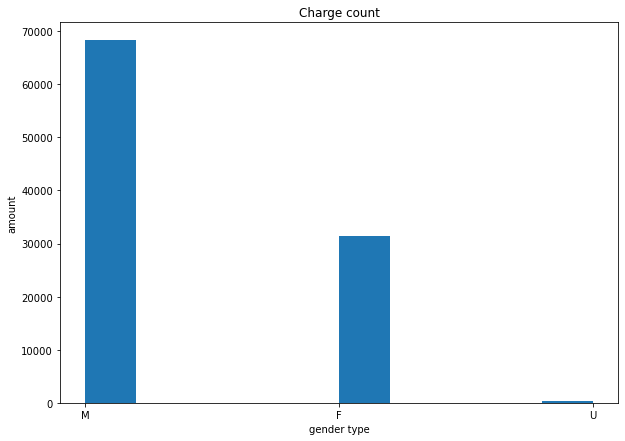

In [50]:
#get a better visual of this by making a hist graph
import matplotlib.pyplot as plt
#who can compare it in many ways, such as gender
plt.figure(figsize=(10,7))
plt.title('Charge count') 
plt.xlabel("gender type") 
plt.ylabel("amount") 
plt.hist(df['gender'])

(array([55900.,     0.,     0.,     0.,     0.,  3218.,     0.,     0.,
            0., 40882.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

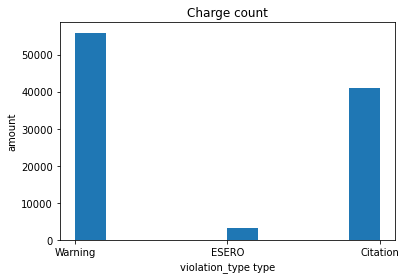

In [51]:
#make
plt.title('Charge count') 
plt.xlabel("violation_type type") 
plt.ylabel("amount") 
plt.hist(df['violation_type'])

(array([9.3973e+04, 2.5240e+03, 2.0330e+03, 6.1900e+02, 1.7100e+02,
        2.6500e+02, 1.9800e+02, 9.8000e+01, 1.0400e+02, 1.5000e+01]),
 array([ 0. ,  5.6, 11.2, 16.8, 22.4, 28. , 33.6, 39.2, 44.8, 50.4, 56. ]),
 <a list of 10 Patch objects>)

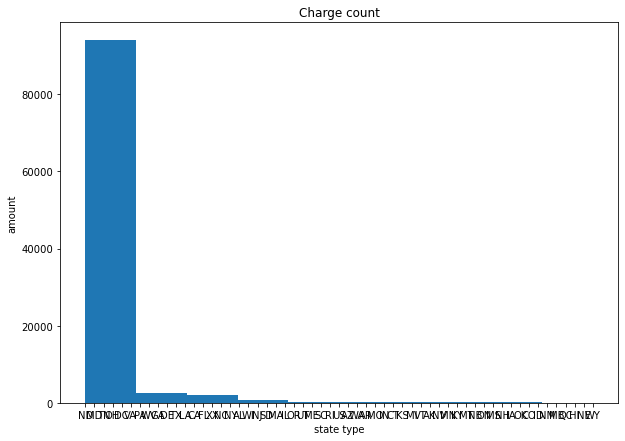

In [52]:
#state
plt.figure(figsize=(10,7))
plt.title('Charge count') 
plt.xlabel("state type") 
plt.ylabel("amount") 
plt.hist(df['state'])

(array([12026.,     0.,  5303.,     0.,     0.,  1851.,     0.,  2342.,
            0.,  4205.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

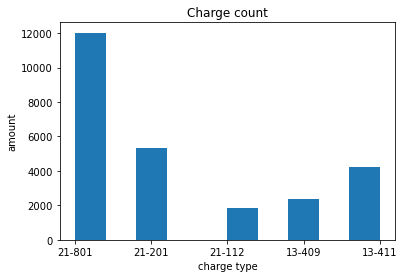

In [53]:
#we are going to moslty focus on the charge type
plt.title('Charge count') 
plt.xlabel("charge type") 
plt.ylabel("amount") 
plt.hist(df_charge['charge'])

In [54]:
#to getting a better picture of the charges, go deeper into it
#lets see how many charges happen on that what weekday


(array([3263., 4558.,    0., 4658.,    0., 4342., 4268.,    0., 2400.,
        2238.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

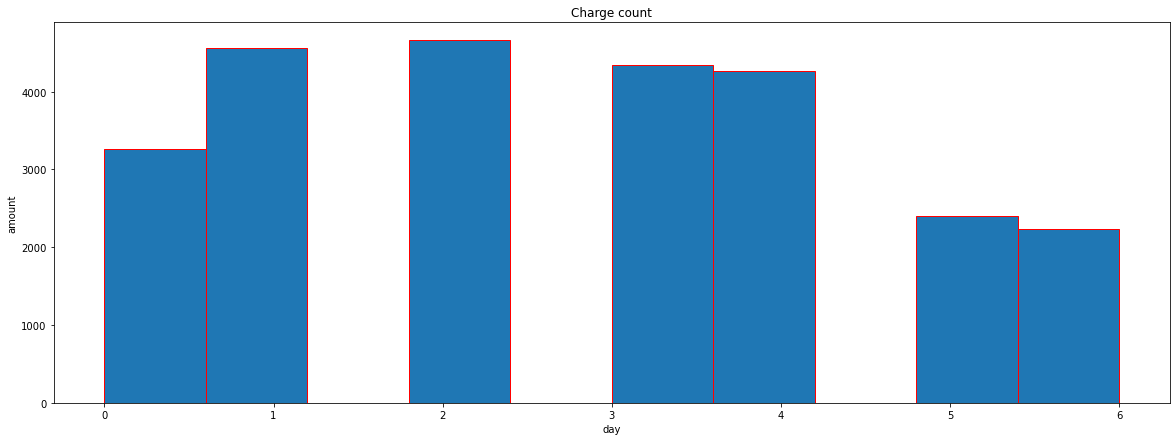

In [55]:
plt.figure(figsize=(20,7))
plt.title('Charge count') 
plt.xlabel("day") 
plt.ylabel("amount") 
plt.hist(df_charge['date_of_stop'],align='mid',edgecolor='red')

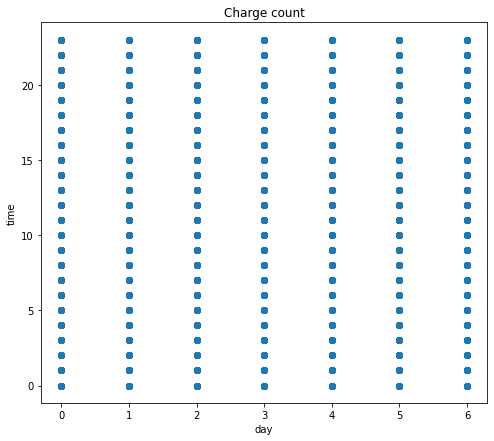

In [56]:
#can make a plot on date x  and time y
plt.figure(figsize=(8,7))
plt.title('Charge count') 
plt.xlabel("day") 
plt.ylabel("time") 
plt.scatter(df_charge['date_of_stop'],df_charge['time_of_stop'])
plt.show()
#this looks like shit, so we can get a better visual if we make a violin plot

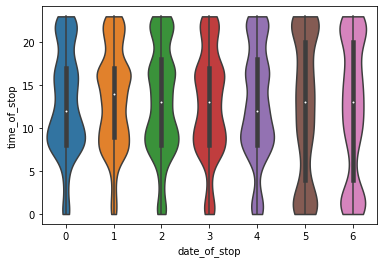

In [57]:
import seaborn as sns
#can make a plot on date x  and time y
sns.violinplot(x = df_charge['date_of_stop'], y= df_charge['time_of_stop'],cut=0)

In [58]:
#looking at this, it looks like at 0 - 4(mon to fri), which is monday, a lot of people have traffic violations at aroung 9am to 3pm. 
# They are probably rushing to work or something and not obeying the laws!
#the weekends, 5 and 6 seem to have more around 12pm 

(array([5461., 5919., 3699.,  481., 2043.,  909.,  784., 1002., 1733.,
        1946., 1750.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 11 Patch objects>)

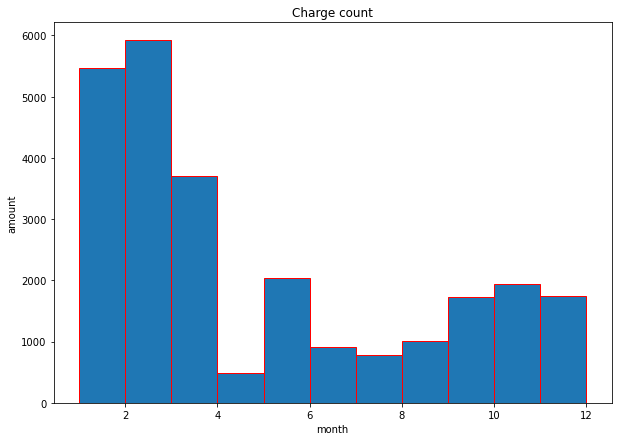

In [59]:
import numpy as np
bins = np.arange(1,13)
plt.figure(figsize=(10,7))
plt.title('Charge count') 
plt.xlabel("month") 
plt.ylabel("amount") 
plt.hist(df_charge['month'],align='mid',edgecolor='red',bins=bins)

In [ ]:
#hypothesis testing and machine learning to provide analysis